In [42]:
import sys
sys.path.append('../')

import numpy as np
import numba as nb
import matplotlib.pyplot as plt
import pandas as pd
import jsonpickle

from particle_filter import particlefilter
from pmcmc import particlemcmc
from math_utils import nbinom_logpmf

In [43]:
'''Import data'''

data = pd.read_csv('../data_sets/ou_SIRS_data_nbinom.csv').to_numpy()
state = pd.read_csv('../data_sets/ou_SIRS_state_nbinom.csv').to_numpy()
betas = pd.read_csv('../data_sets/ou_SIRS_betas_nbinom.csv').to_numpy()

In [44]:
def SIRS_model(particles,observations,t,dt,model_params,rng):
    '''Definition of SEIR model as described in Calvetti's paper. Difference 
    is the use of Tau leaping to introduce stochasticity into the system and continuous log-normal OU process definition for beta.'''
    gamma,xi,sig,mu,lam,R = model_params

    A = np.exp(-lam * dt)
    M = mu * (np.exp(-lam * dt) - 1)
    C = sig * np.sqrt(1 - np.exp(-2 * lam * dt))

    '''Tau leaping. Non estimated parameters are hard coded. '''

    for index in range(particles.shape[0]):

        new_I = rng.poisson((particles[index,3,t] * particles[index, 1, t]* particles[index, 0, t])/np.sum(particles[index,:,t]) * dt)
        new_S = rng.poisson((xi * particles[index,2,t]) * dt)
        new_R = rng.poisson((gamma * particles[index,1,t]) * dt)

        particles[index,0,t] = np.maximum(0.,particles[index,0,t] - new_I + new_S) #S
        particles[index,1,t] = np.maximum(0.,particles[index,1,t] + new_I - new_R) #I
        particles[index,2,t] = np.maximum(0.,particles[index,2,t] + new_R-new_S) #R

        particles[index,3,t] = np.exp(A * np.log(particles[index,3,t]) - M + C * rng.standard_normal())

        observations[index,0,t] = particles[index,1,t]

    return particles,observations

def SIRS_Obs(data_point, particle_observations, model_params):
    r = 1/model_params[5]
    weights = nbinom_logpmf(x = data_point,p = r/(r + particle_observations[:,0] + 0.005),n = np.array([r]))
    return weights


In [45]:
'''True parameter values'''
rng = np.random.default_rng(0)

'''unpickle parameter sets'''
with open("../param_sets/SIRS_OU_model_params.json", "r+") as f:
    SIRS_model_json = f.read()
    SIRS_model_params = jsonpickle.decode(SIRS_model_json)

gamma = SIRS_model_params['gamma']
R = SIRS_model_params['R']
xi = SIRS_model_params['xi']

with open("../param_sets/SIRS_OU_process_params.json", "r+") as f:
    OU_process_json = f.read()
    SIRS_OU_process_params = jsonpickle.decode(OU_process_json)

lam = SIRS_OU_process_params['lambda']
mean_ou = SIRS_OU_process_params['mean_ou']
sig = SIRS_OU_process_params['sig']

T = 2 * 365
dt = 0.1
t_vec = np.arange(0,T,dt)

def SIRS_init(num_particles, model_dim, rng):
    particles_0 = np.zeros((num_particles,model_dim))
    particles_0[:,0] = 500
    I_init = rng.integers(1,5,size = (num_particles))
    particles_0[:,0] -= I_init
    particles_0[:,1] = I_init
    particles_0[:,3] = rng.uniform(0.,1., size = (num_particles,))
    

    return particles_0

pf_params = {'num_particles':10_000, 
                      'dt':dt,
                      'model':SIRS_model,
                      'observation_model':SIRS_Obs,
                      'model_dim':4,
                      'particle_initializer':SIRS_init,
                      }

from time import perf_counter

t = perf_counter()
output = particlefilter(data = data,
        model_params= (gamma,xi,sig,mean_ou,lam,1/R),
        pf_params = pf_params,
        rng = rng,
        req_jit=True
        )

print(perf_counter() - t)

15.874376610001491


 Log Likelihood : -2223.3358567459527
Root Mean Squared Error for the Data 32.90450888277222


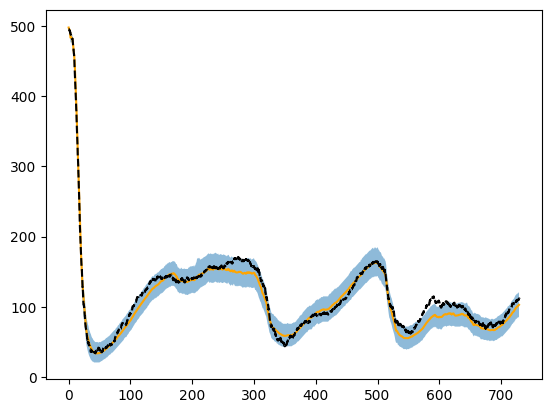

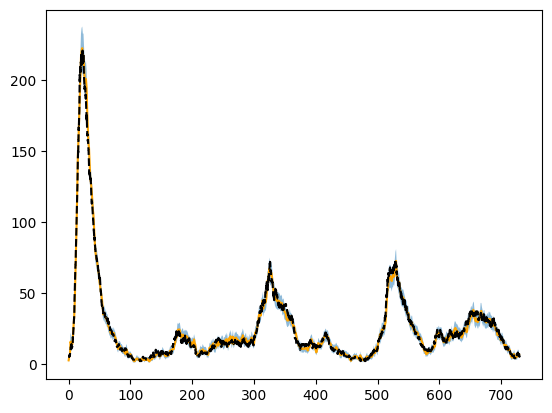

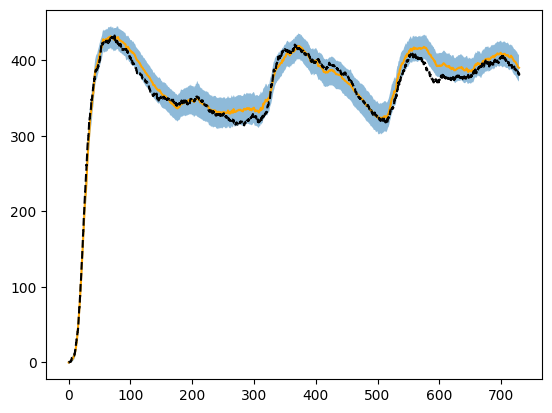

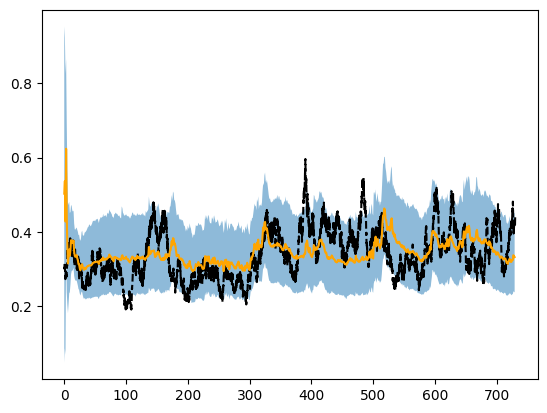

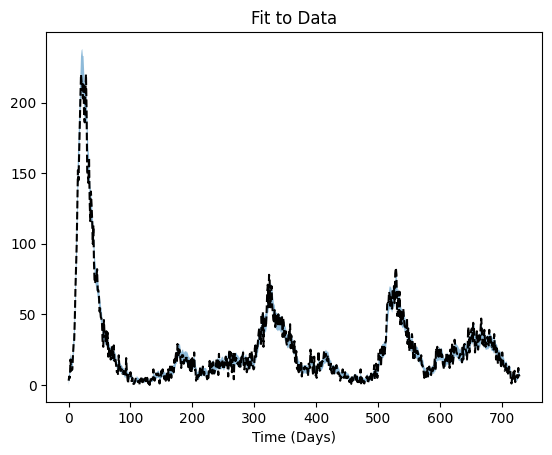

In [47]:
print(f" Log Likelihood : {np.sum(output['Log_likelihood'])}")

print(f"Root Mean Squared Error for the Data {np.sqrt(np.mean((data - np.mean(output['particle_observations'][:,0,:]))**2))}")

for i in range(3):
    plt.fill_between(t_vec[::int(1/dt)],np.percentile(output['particle_distribution'][:,i,:].T,5,axis = 1),np.percentile(output['particle_distribution'][:,i,:].T,95,axis = 1),alpha = 0.5)
    plt.plot(np.average(output['particle_distribution'][:,i,:],weights = np.exp(output['log_weights']),axis = 0),color = 'orange')
    plt.plot(t_vec,state[i,:].T,'--',color = 'black')
    plt.show()

plt.plot(t_vec,betas,'--',color = 'black')
plt.fill_between(t_vec[::int(1/dt)],np.percentile(output['particle_distribution'][:,3,:].T,5,axis = 1),np.percentile(output['particle_distribution'][:,3,:].T,95,axis = 1),alpha = 0.5)
plt.plot(np.average(output['particle_distribution'][:,3,:],weights = np.exp(output['log_weights']),axis = 0),color = 'orange')
plt.show()

plt.title("Fit to Data")
plt.xlabel('Time (Days)')
plt.plot(t_vec[::int(1/dt)],data.T,'--',color = 'black')
plt.fill_between(t_vec[::int(1/dt)],np.percentile(output['particle_observations'][:,0,:].T,5,axis = 1),np.percentile(output['particle_observations'][:,0,:].T,95,axis = 1),alpha = 0.5)
plt.show()